In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score





#  1️⃣ 데이터 불러오기 및 결측치 처리

*   월세부분 삭제하고 전세건만 사용
*   널과 확인 및 필요 없는 컬럼 삭제






In [ ]:
url = "/content/아파트(전세)_서울마포구_20250928.csv"
try:
    df = pd.read_csv(url, encoding="utf-8", engine="python", sep=",")
except:
    try:
        df = pd.read_csv(url, encoding="cp949", engine="python", sep=",")
    except:
        print("Could not read the CSV file with utf-8 or cp949 encoding.")
        df = None


if df is not None:
    # 전세만 남기기
    df = df[df["월세금(만원)"] == 0].copy()
    df["보증금(만원)"] = df["보증금(만원)"].astype(str).str.replace(",", "").astype(int)

    # 필요한 컬럼만 남기기
    cols = ["시군구", "단지명", "전용면적(㎡)", "계약년월", "계약일", "보증금(만원)", "층", "건축년도", "계약구분"]
    df = df[cols].dropna()
else:
    print("DataFrame is empty due to reading error.")


#  2️⃣ X, y 분리


In [ ]:
y = df["보증금(만원)"]
X = df.drop(columns=["보증금(만원)"])

# 범주형, 수치형 분리
cat_cols = ["시군구", "단지명", "계약구분"]
num_cols = ["전용면적(㎡)", "계약년월", "계약일", "층", "건축년도"]


# 3️⃣ 전처리 파이프라인 구성


*   숫치 컬럼
*   문자 컬럼 숫치화



In [ ]:

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)



# 4️⃣ 모델 정의


*   Linear Regression 선형 회귀
*   Random Forest 랜덤 포레스트



In [ ]:
lr_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=300, random_state=42, max_depth=15, n_jobs=-1))
])


# 5️⃣ Train/Test Split


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 6️⃣ 학습


In [ ]:
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['전용면적(㎡)', '계약년월', '계약일',
                                                   '층', '건축년도']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['시군구', '단지명', '계약구분'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=15, n_estimators=300,
                                       n_jobs=-1, random_state=42))])


# 7️⃣ 예측


In [ ]:

y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)


# 8️⃣ 평가 함수


In [ ]:


def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"📊 {name} 결과:")
    print(f"MAE : {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"R²  : {r2:.4f}")
    print("-" * 40)

evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)

📊 Linear Regression 결과:
MAE : 6,877.79
RMSE: 10,556.80
R²  : 0.8584
----------------------------------------
📊 Random Forest 결과:
MAE : 5,519.34
RMSE: 8,446.14
R²  : 0.9094
----------------------------------------



# 9️⃣ RandomForest 특성 중요도 시각화


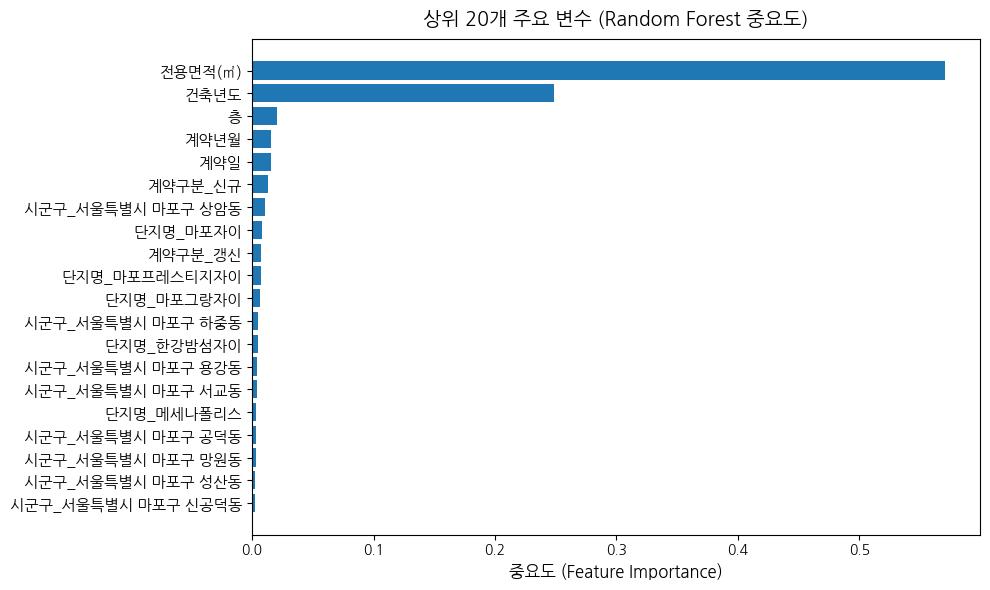

In [ ]:
# ✅ 2) 중요도 시각화 (한글 정상 표기)
# 한글 폰트 설정
mpl.rcParams['axes.unicode_minus'] = False
sysname = platform.system()
if sysname == "Windows":
    mpl.rcParams['font.family'] = "Malgun Gothic"
elif sysname == "Darwin":
    mpl.rcParams['font.family'] = "AppleGothic"
else:
    # Linux (Colab)
    try:
        nanum = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
        if not os.path.exists(nanum):
            import subprocess
            subprocess.run(["apt-get", "-qq", "update"], check=True)
            subprocess.run(["apt-get", "-qq", "-y", "install", "fonts-nanum"], check=True)
        if os.path.exists(nanum):
            fm.fontManager.addfont(nanum)
            mpl.rcParams['font.family'] = "NanumGothic"
    except Exception:
        pass
# 파이프라인에서 OneHotEncoder 이후의 feature 이름을 추출
ohe = rf_model.named_steps["preprocessor"].named_transformers_["cat"]
encoded_features = ohe.get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, encoded_features])

# feature importance
rf = rf_model.named_steps["regressor"]
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:20]  # 상위 20개만

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), np.array(all_features)[indices][::-1], fontsize=11)
plt.xlabel("중요도 (Feature Importance)", fontsize=12)
plt.title("상위 20개 주요 변수 (Random Forest 중요도)", fontsize=14, pad=10)
plt.tight_layout()
plt.show()


In [ ]:
# 예시: RandomForestRegressor 모델이라면
pred = rf_model.predict(X_test)

In [ ]:
import numpy as np
import pandas as pd

# 전제: X_test (원본 형태 DataFrame), y_test (Series/ndarray), pred (ndarray)
X_test_orig = X_test.copy()

y_true = np.array(y_test).reshape(-1)
y_pred = np.array(pred).reshape(-1)

res = X_test_orig.reset_index(drop=True).copy()
res["실제전세금(만원)"] = y_true
res["예측전세금(만원)"] = y_pred

# ✅ 저평가 지표: 예측 - 실제 (클수록 더 저평가)
res["저평가금액(만원)"] = res["예측전세금(만원)"] - res["실제전세금(만원)"]          # > 0 이면 저평가
res["저평가율(%)"]   = np.where(res["예측전세금(만원)"] > 0,
                             res["저평가금액(만원)"] / res["예측전세금(만원)"] * 100,
                             np.nan)

# 음수(=과대평가) 제거하고 저평가만 남기기
undervalued = res[res["저평가금액(만원)"] > 0].copy()

# 저평가 정도 큰 순서 (금액 기준)
undervalued_top20_amt = undervalued.sort_values("저평가금액(만원)", ascending=False).head(20)

# 저평가율 큰 순서 (비율 기준)
undervalued_top20_rate = undervalued.sort_values("저평가율(%)", ascending=False).head(20)

print("✅ 저평가 Top20 (금액 기준)")
cols_pref = [c for c in ["시군구","단지명","전용면적(㎡)","층","건축년도","계약년월","계약일"] if c in undervalued.columns]
display(undervalued_top20_amt[cols_pref + ["예측전세금(만원)","실제전세금(만원)","저평가금액(만원)","저평가율(%)"]])

print("✅ 저평가 Top20 (비율 기준)")
display(undervalued_top20_rate[cols_pref + ["예측전세금(만원)","실제전세금(만원)","저평가금액(만원)","저평가율(%)"]])


✅ 저평가 Top20 (금액 기준)


,시군구,단지명,전용면적(㎡),층,건축년도,계약년월,계약일,예측전세금(만원),실제전세금(만원),저평가금액(만원),저평가율(%)
976,서울특별시 마포구 아현동,마포래미안푸르지오1단지,84.8919,23,2014,202410,7,90252.675909,20000,70252.675909,77.839992
1018,서울특별시 마포구 상암동,상암월드컵파크5단지,104.6900,18,2005,202505,14,76973.125168,10000,66973.125168,87.008453
397,서울특별시 마포구 용강동,래미안마포리버웰,114.6600,4,2015,202501,21,138581.367304,80000,58581.367304,42.272182
703,서울특별시 마포구 서교동,대우미래사랑,84.9600,5,2005,202505,12,66176.687073,8000,58176.687073,87.911151
561,서울특별시 마포구 중동,동원월드타운,84.8690,3,2004,202507,9,64697.303146,30000,34697.303146,53.630216
898,서울특별시 마포구 현석동,래미안웰스트림,84.9800,16,2016,202505,5,102447.275684,70000,32447.275684,31.672170
365,서울특별시 마포구 하중동,한강밤섬자이,132.5400,23,2010,202504,23,140154.666667,110000,30154.666667,21.515278
731,서울특별시 마포구 상암동,상암월드컵파크7단지,84.9000,6,2005,202502,13,66069.633867,39000,27069.633867,40.971370
311,서울특별시 마포구 망원동,길명2차(455-4),131.1880,5,2005,202503,17,85022.954620,58000,27022.954620,31.783128
1020,서울특별시 마포구 서교동,광남벨라스(1차),121.3400,6,2004,202502,28,79223.142011,52500,26723.142011,33.731485


✅ 저평가 Top20 (비율 기준)


,시군구,단지명,전용면적(㎡),층,건축년도,계약년월,계약일,예측전세금(만원),실제전세금(만원),저평가금액(만원),저평가율(%)
703,서울특별시 마포구 서교동,대우미래사랑,84.9600,5,2005,202505,12,66176.687073,8000,58176.687073,87.911151
1018,서울특별시 마포구 상암동,상암월드컵파크5단지,104.6900,18,2005,202505,14,76973.125168,10000,66973.125168,87.008453
976,서울특별시 마포구 아현동,마포래미안푸르지오1단지,84.8919,23,2014,202410,7,90252.675909,20000,70252.675909,77.839992
1191,서울특별시 마포구 창전동,창전래미안,32.7600,2,1998,202504,17,10633.754615,3648,6985.754615,65.694149
711,서울특별시 마포구 대흥동,대흥동태영아파트,32.4000,3,1999,202412,17,10676.402397,3721,6955.402397,65.147436
985,서울특별시 마포구 대흥동,대흥동태영아파트,32.4000,10,1999,202412,19,10293.780781,3721,6572.780781,63.851960
56,서울특별시 마포구 대흥동,대흥동태영아파트,32.4000,14,1999,202411,29,8027.475841,3721,4306.475841,53.646699
561,서울특별시 마포구 중동,동원월드타운,84.8690,3,2004,202507,9,64697.303146,30000,34697.303146,53.630216
959,서울특별시 마포구 용강동,이편한세상마포리버파크,49.6500,8,2016,202504,21,17058.368422,8391,8667.368422,50.810067
141,서울특별시 마포구 연남동,광남벨라스(VALLACE),53.7900,6,2003,202410,25,52647.864757,26000,26647.864757,50.615281


#

# 추가 작업할 내용

1.   같은 아파트의 그룹화 비교후 결정 박스플루우 해서 확인 전세금 8000만원이 상식선에서 벗어난 항목을 확인. (원인 확인 후 조치 필요)
2.   같은 브랜드 아파트 그룹화해서 전세금 비교 분석해서 오차범위를 좁힐 수 있는지 확인.
3.   데이터 결측치 처리 단계에서 갱신청구권 사용한 항목을 삭제.(이유: 갱신청구권 사용시 전세금 인상폭을 5%내로 제한)
4.   저평가 금액및 저평가 율을 재 정의.(평균 편차와 비교)
5.   새컬럼 추가 (지하철역과의 거리, 학교와의 거리, 대형 마트와의 거리)


<Figure size 1200x600 with 0 Axes>

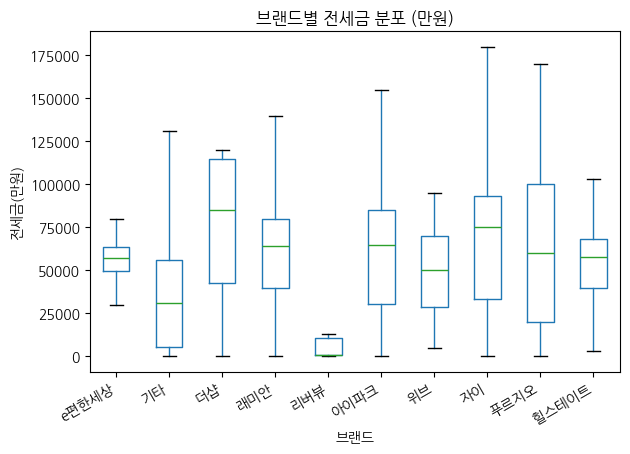

[저장] 브랜드별_전세금_분포_boxplot.png


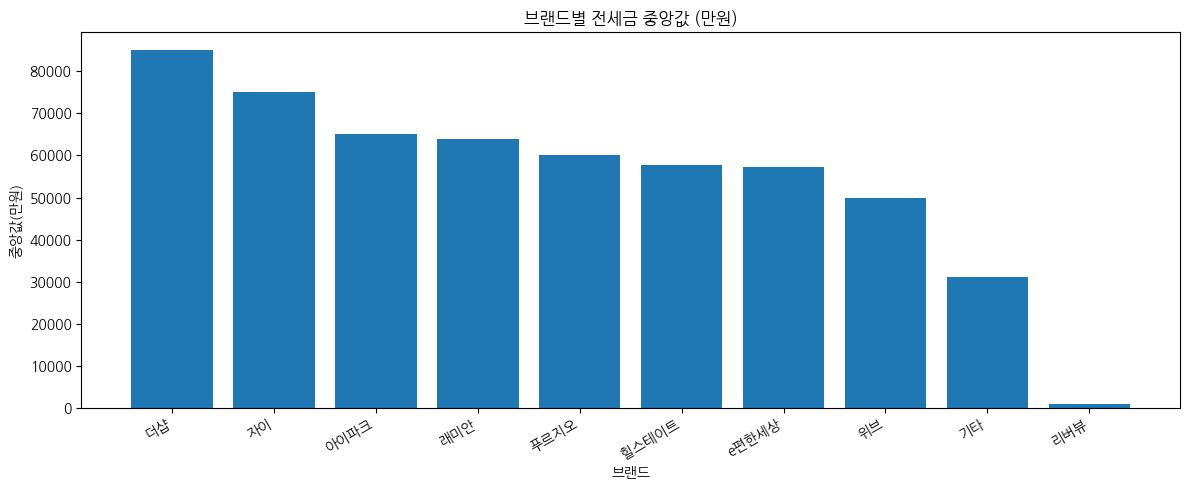

[저장] 브랜드별_전세금_중앙값_bar.png


<Figure size 1200x600 with 0 Axes>

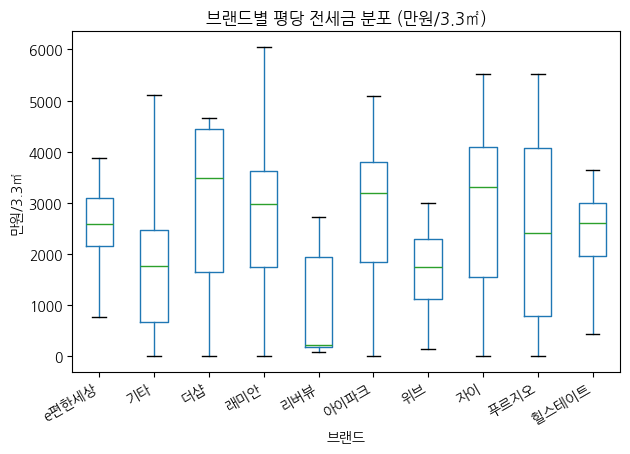

[저장] 브랜드별_평당전세금_분포_boxplot.png


In [1]:
# -*- coding: utf-8 -*-
import os
import re
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# =========================
# 0) 환경: 한글 폰트 설정
# =========================
mpl.rcParams['axes.unicode_minus'] = False
sysname = platform.system()
if sysname == "Windows":
    mpl.rcParams['font.family'] = "Malgun Gothic"
elif sysname == "Darwin":
    mpl.rcParams['font.family'] = "AppleGothic"
else:
    # Linux/Colab: 나눔고딕 설치 시도
    try:
        nanum = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
        if not os.path.exists(nanum):
            import subprocess
            subprocess.run(["apt-get", "-qq", "update"], check=True)
            subprocess.run(["apt-get", "-qq", "-y", "install", "fonts-nanum"], check=True)
        if os.path.exists(nanum):
            fm.fontManager.addfont(nanum)
            mpl.rcParams['font.family'] = "NanumGothic"
    except Exception:
        pass

# =========================
# 1) 데이터 로드 & 정리
# =========================
CSV_PATH = "아파트(전세)_서울마포구_20250928.csv"  # 파일 경로를 환경에 맞게 수정

# 인코딩 시도
try:
    df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")
except UnicodeDecodeError:
    df = pd.read_csv(CSV_PATH, encoding="cp949")

# 필수 컬럼 점검
need_cols = ["단지명", "보증금(만원)"]
missing = [c for c in need_cols if c not in df.columns]
if missing:
    raise ValueError(f"필수 컬럼 누락: {missing}")

# 보증금 숫자화 (문자열에 쉼표가 있을 수 있음)
if df["보증금(만원)"].dtype == object:
    df["보증금(만원)"] = (
        df["보증금(만원)"].astype(str).str.replace(",", "", regex=False)
        .replace({"": np.nan, "-": np.nan})
        .astype(float)
    )

# =========================
# 2) 단지명 → 브랜드 추출
# =========================
# 자주 쓰이는 브랜드 키워드 패턴 (필요시 추가/수정)
brand_patterns = [
    (r"래미안", "래미안"),
    (r"자이", "자이"),
    (r"푸르지오", "푸르지오"),
    (r"롯데\s*캐슬|롯데캐슬", "롯데캐슬"),
    (r"힐스테이트", "힐스테이트"),
    (r"e\s*편한세상|e편한세상|e-편한세상", "e편한세상"),
    (r"아이파크|IPARK", "아이파크"),
    (r"더샵", "더샵"),
    (r"센트레빌", "센트레빌"),
    (r"위브", "위브"),
    (r"스위첸", "스위첸"),
    (r"호반\s*베르디움|베르디움", "호반베르디움"),
    (r"우남", "우남"),
    (r"두산위브", "두산위브"),
    (r"트리마제", "트리마제"),
    (r"리버뷰|리버스", "리버뷰"),
    (r"리센츠", "리센츠"),
    (r"수자인", "수자인"),
    (r"에코델타|에코", "에코"),
    # 필요 시 계속 추가
]

def extract_brand(name: str) -> str:
    if not isinstance(name, str):
        return "기타"
    for pat, label in brand_patterns:
        if re.search(pat, name, flags=re.IGNORECASE):
            return label
    return "기타"

df["브랜드"] = df["단지명"].apply(extract_brand)

# =========================
# 3) 분석용 필터 (옵션)
# =========================
# 표본이 너무 적은 브랜드는 제외 (예: 10건 미만 제거)
min_samples = 10
brand_counts = df.groupby("브랜드")["보증금(만원)"].count()
valid_brands = brand_counts[brand_counts >= min_samples].index.tolist()
df_plot = df[df["브랜드"].isin(valid_brands)].dropna(subset=["보증금(만원)"])

if df_plot.empty:
    raise ValueError("유효 브랜드 표본이 없습니다. min_samples를 낮추거나 brand_patterns를 점검하세요.")

# =========================
# 4) Boxplot: 브랜드별 전세금 분포
# =========================
plt.figure(figsize=(12, 6))
# 브랜드 정렬: 중앙값 높은 순
order = (
    df_plot.groupby("브랜드")["보증금(만원)"]
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)
# 박스플롯
df_plot.boxplot(column="보증금(만원)", by="브랜드", grid=False, showfliers=False)
plt.suptitle("")  # 자동 제목 제거
plt.title("브랜드별 전세금 분포 (만원)")
plt.xlabel("브랜드")
plt.ylabel("전세금(만원)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
BOX_PNG = "브랜드별_전세금_분포_boxplot.png"
plt.savefig(BOX_PNG, dpi=150)
plt.show()
print(f"[저장] {BOX_PNG}")

# =========================
# 5) Bar: 브랜드별 전세금 중앙값 (옵션)
# =========================
median_by_brand = (
    df_plot.groupby("브랜드")["보증금(만원)"]
    .median()
    .sort_values(ascending=False)
)
plt.figure(figsize=(12, 5))
plt.bar(median_by_brand.index, median_by_brand.values)
plt.title("브랜드별 전세금 중앙값 (만원)")
plt.xlabel("브랜드")
plt.ylabel("중앙값(만원)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
BAR_PNG = "브랜드별_전세금_중앙값_bar.png"
plt.savefig(BAR_PNG, dpi=150)
plt.show()
print(f"[저장] {BAR_PNG}")

# =========================
# 6) (선택) 면적 보정 비교: 3.3㎡당 전세금
# =========================
if "전용면적(㎡)" in df_plot.columns:
    df_area = df_plot.copy()
    df_area = df_area[df_area["전용면적(㎡)"] > 0]
    # 3.3㎡(1평)당 전세금(만원)
    df_area["평당전세금(만원)"] = df_area["보증금(만원)"] / (df_area["전용면적(㎡)"] / 3.3)

    # 박스플롯 (평당)
    plt.figure(figsize=(12, 6))
    df_area.boxplot(column="평당전세금(만원)", by="브랜드", grid=False, showfliers=False)
    plt.suptitle("")
    plt.title("브랜드별 평당 전세금 분포 (만원/3.3㎡)")
    plt.xlabel("브랜드")
    plt.ylabel("만원/3.3㎡")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    PER_PNG = "브랜드별_평당전세금_분포_boxplot.png"
    plt.savefig(PER_PNG, dpi=150)
    plt.show()
    print(f"[저장] {PER_PNG}")



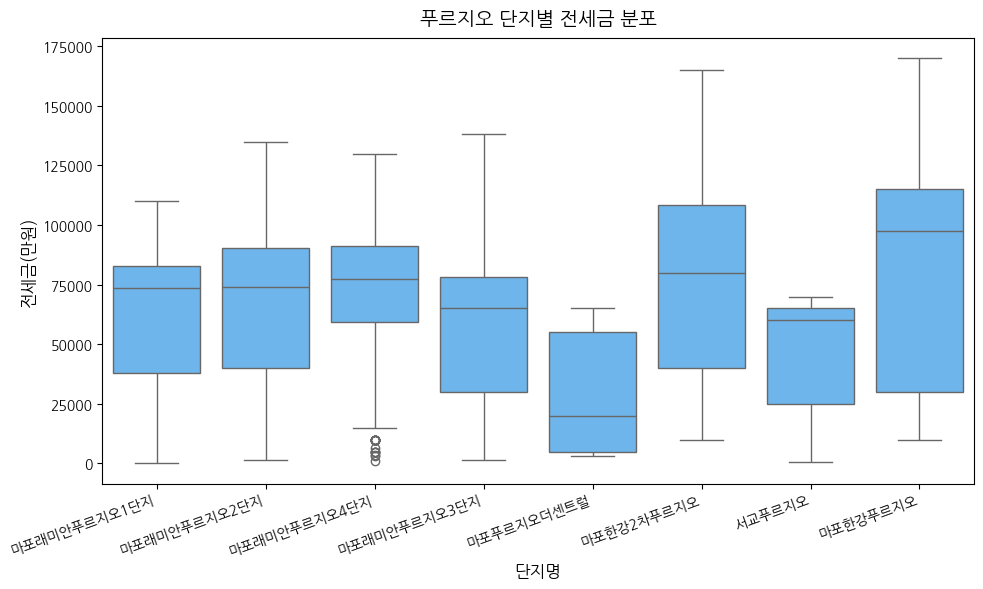

In [6]:
import seaborn as sns

# ====== 2️⃣ 데이터 로드 ======
file_path = "아파트(전세)_서울마포구_20250928.csv"

try:
    df = pd.read_csv(file_path, encoding="utf-8-sig")
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding="cp949")

# ====== 3️⃣ 데이터 전처리 ======
# 보증금 컬럼 정리
df["보증금(만원)"] = (
    df["보증금(만원)"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace({"": None, "-": None})
    .astype(float)
)

# 푸르지오만 필터링
df_p = df[df["단지명"].str.contains("푸르지오", na=False)]

if df_p.empty:
    raise ValueError("데이터 내에 '푸르지오' 단지가 없습니다. 철자 확인 필요.")

# ====== 4️⃣ 박스플롯 시각화 ======
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_p,
    x="단지명",
    y="보증금(만원)",
    color="#58B8FF"
)
plt.title("푸르지오 단지별 전세금 분포", fontsize=14, pad=10)
plt.xlabel("단지명", fontsize=12)
plt.ylabel("전세금(만원)", fontsize=12)
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

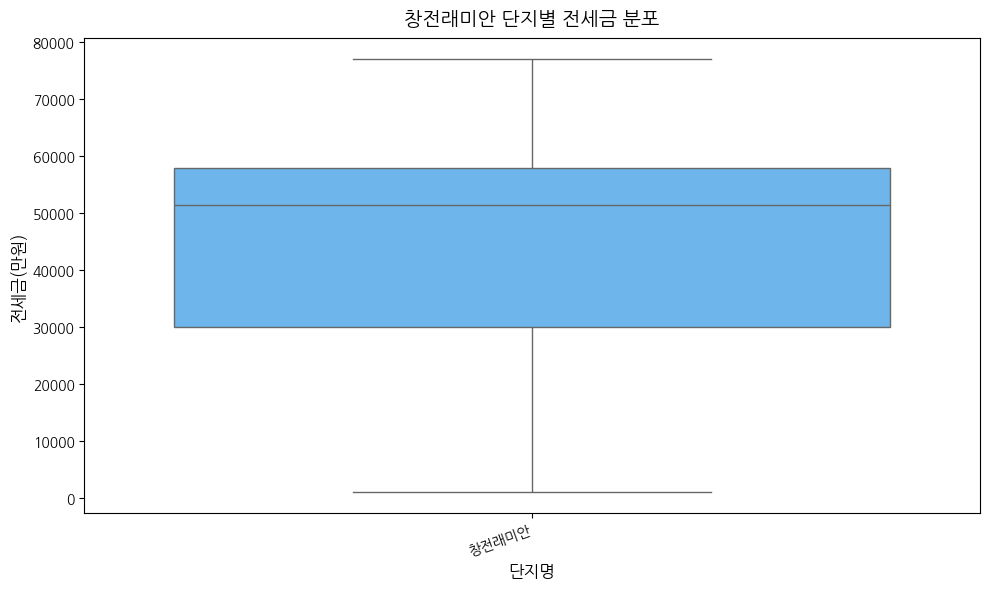

In [7]:
import seaborn as sns

# ====== 2️⃣ 데이터 로드 ======
file_path = "아파트(전세)_서울마포구_20250928.csv"

try:
    df = pd.read_csv(file_path, encoding="utf-8-sig")
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding="cp949")

# ====== 3️⃣ 데이터 전처리 ======
# 보증금 컬럼 정리
df["보증금(만원)"] = (
    df["보증금(만원)"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace({"": None, "-": None})
    .astype(float)
)

# 푸르지오만 필터링
df_p = df[df["단지명"].str.contains("창전래미안", na=False)]

if df_p.empty:
    raise ValueError("데이터 내에 '창전래미안' 단지가 없습니다. 철자 확인 필요.")

# ====== 4️⃣ 박스플롯 시각화 ======
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_p,
    x="단지명",
    y="보증금(만원)",
    color="#58B8FF"
)
plt.title("창전래미안 단지별 전세금 분포", fontsize=14, pad=10)
plt.xlabel("단지명", fontsize=12)
plt.ylabel("전세금(만원)", fontsize=12)
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
#대흥동태영아파트


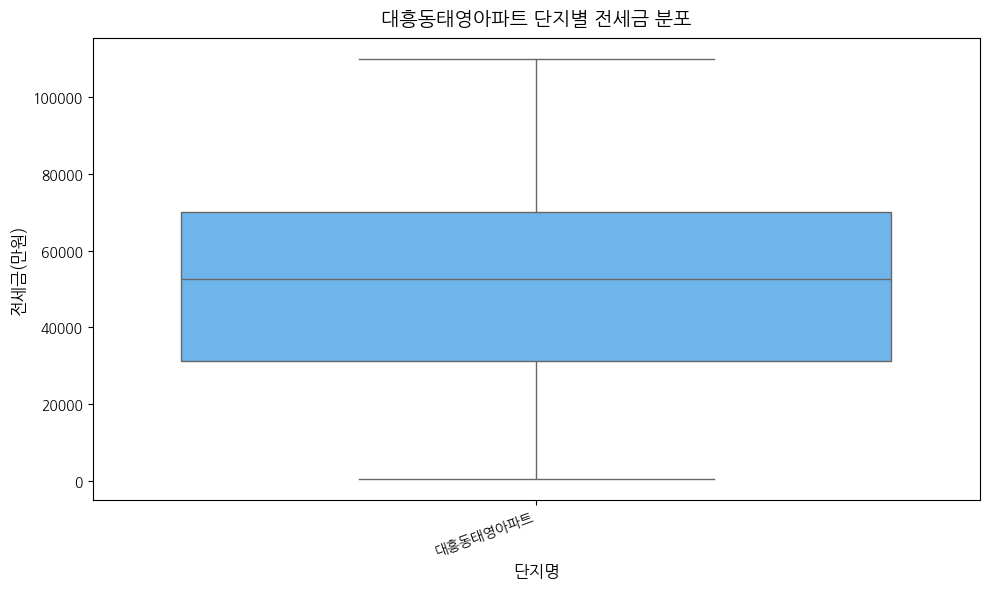

In [8]:
import seaborn as sns

# ====== 2️⃣ 데이터 로드 ======
file_path = "아파트(전세)_서울마포구_20250928.csv"

try:
    df = pd.read_csv(file_path, encoding="utf-8-sig")
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding="cp949")

# ====== 3️⃣ 데이터 전처리 ======
# 보증금 컬럼 정리
df["보증금(만원)"] = (
    df["보증금(만원)"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace({"": None, "-": None})
    .astype(float)
)

# 푸르지오만 필터링
df_p = df[df["단지명"].str.contains("대흥동태영아파트", na=False)]

if df_p.empty:
    raise ValueError("데이터 내에 '대흥동태영아파트' 단지가 없습니다. 철자 확인 필요.")

# ====== 4️⃣ 박스플롯 시각화 ======
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_p,
    x="단지명",
    y="보증금(만원)",
    color="#58B8FF"
)
plt.title("대흥동태영아파트 단지별 전세금 분포", fontsize=14, pad=10)
plt.xlabel("단지명", fontsize=12)
plt.ylabel("전세금(만원)", fontsize=12)
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()